In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/train.csv')

In [4]:
X = data[['Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']]
X.head()

,Pclass,Age,Sex,SibSp,Parch,Fare,Embarked
0,3,22.0,male,1,0,7.2500,S
1,1,38.0,female,1,0,71.2833,C
2,3,26.0,female,0,0,7.9250,S
3,1,35.0,female,1,0,53.1000,S
4,3,35.0,male,0,0,8.0500,S


In [5]:
y = data[['Survived']]
y

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [6]:
X['Age'].fillna(X['Age'].median(skipna=True), inplace=True)
X['Embarked'].fillna(X['Embarked'].value_counts().idxmax(), inplace=True)

In [7]:
encoder = ce.OrdinalEncoder(cols=['Sex', 'Embarked'])
X = encoder.fit_transform(X)
X

,Pclass,Age,Sex,SibSp,Parch,Fare,Embarked
0,3,22.0,1,1,0,7.2500,1
1,1,38.0,2,1,0,71.2833,2
2,3,26.0,2,0,0,7.9250,1
3,1,35.0,2,1,0,53.1000,1
4,3,35.0,1,0,0,8.0500,1
...,...,...,...,...,...,...,...
886,2,27.0,1,0,0,13.0000,1
887,1,19.0,2,0,0,30.0000,1
888,3,28.0,2,1,2,23.4500,1
889,1,26.0,1,0,0,30.0000,2


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=8)

In [9]:
X_train.shape, y_test.shape

((712, 7), (179, 1))

In [10]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [11]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [12]:
n_HP_points_to_test = 100

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)
# best_model = gs.best_estimator_

In [13]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[100]	valid's auc: 0.78482
[100]	valid's auc: 0.789776
[100]	valid's auc: 0.809077
[100]	valid's auc: 0.801187
Best score reached: 0.8517240758737357 with params: {'colsample_bytree': 0.5284213741879101, 'min_child_samples': 125, 'min_child_weight': 10.0, 'num_leaves': 22, 'reg_alpha': 0.1, 'reg_lambda': 20, 'subsample': 0.3080033455431848} 


In [14]:
best_model= gs.best_estimator_

In [15]:
accuracy_score(y_test, best_model.predict(X_test))

0.7374301675977654

In [16]:
f1_score(y_test, best_model.predict(X_test))

0.6466165413533835

In [17]:
print(confusion_matrix(y_test, best_model.predict(X_test)))

[[89 19]
 [28 43]]


In [18]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       108
           1       0.69      0.61      0.65        71

    accuracy                           0.74       179
   macro avg       0.73      0.71      0.72       179
weighted avg       0.73      0.74      0.73       179



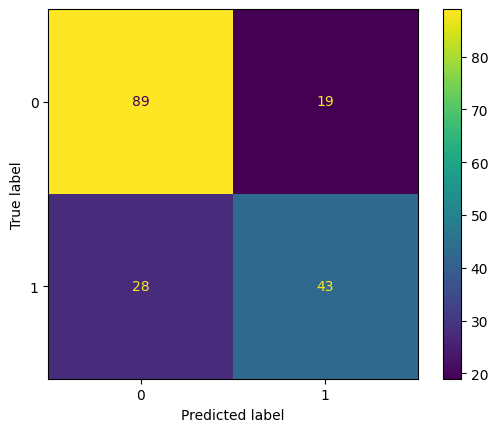

In [19]:
cm = confusion_matrix(y_test, best_model.predict(X_test), labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

In [35]:
model = lgb.LGBMRegressor()

# Define the hyperparameters to tune
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [20, 50, 100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train a new model with the best parameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = best_model.score(X_test, y_test)

# Print the results
print("Best parameters:", best_params)
print("Best score:", best_score)
print("Test score:", test_score)


Best parameters: {'learning_rate': 0.2, 'n_estimators': 20, 'num_leaves': 30}
Best score: 0.4304501377665357
Test score: 0.4140661045366828


In [36]:
binary_predictions = [1 if pred > 0.5 else 0 for pred in best_model.predict(X_test)]

In [37]:
accuracy_score(y_test, binary_predictions)

0.8212290502793296

In [38]:
f1_score(y_test, binary_predictions)

0.7714285714285714

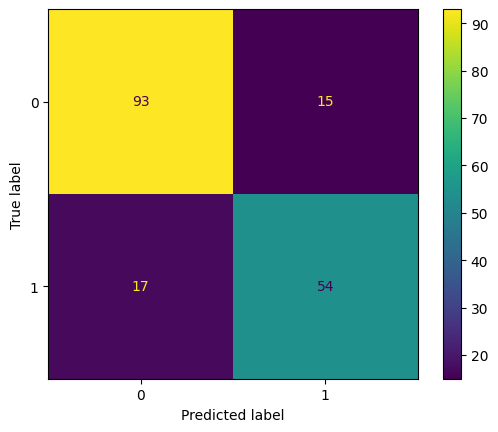

In [39]:
cm = confusion_matrix(y_test, binary_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [40]:
data2 = pd.read_csv('data/test.csv')

In [43]:
data2.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [44]:
X_original = data2[['Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [46]:
X_original.isnull().sum()

Pclass       0
Age         86
Sex          0
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [49]:
X_original['Age'].fillna(X_original['Age'].mean(skipna=True), inplace=True)
X_original['Fare'].fillna(X_original['Fare'].mean(skipna=True), inplace=True)

In [50]:
encoder = ce.OrdinalEncoder(cols=['Sex', 'Embarked'])
X_original = encoder.fit_transform(X)
X_original

,Pclass,Age,Sex,SibSp,Parch,Fare,Embarked
0,3,22.0,1,1,0,7.2500,1
1,1,38.0,2,1,0,71.2833,2
2,3,26.0,2,0,0,7.9250,1
3,1,35.0,2,1,0,53.1000,1
4,3,35.0,1,0,0,8.0500,1
...,...,...,...,...,...,...,...
886,2,27.0,1,0,0,13.0000,1
887,1,19.0,2,0,0,30.0000,1
888,3,28.0,2,1,2,23.4500,1
889,1,26.0,1,0,0,30.0000,2


In [53]:
y_original =  [1 if pred > 0.5 else 0 for pred in best_model.predict(X_original)]

In [59]:
y_original

[0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,


In [64]:
Submission = data2[['PassengerId']]

In [65]:
Submission

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [66]:
new = pd.DataFrame(y_original)

In [67]:
Submission['Survived'] = new

In [68]:
Submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,1


In [69]:
Submission.to_csv('Submission.csv', index=False)